In [1]:
import streamlit as st
import os
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
import os
import time
import json
from PIL import Image
import matplotlib.pyplot as plt

/Users/arindam/Machine Learning/GitHub_Repository/ShopChatApp/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arindam/Machine Learning/GitHub_Repository/ShopChatApp/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")
llm        = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0)
#llm        = GoogleGenerativeAI(model="models/text-bison-001", temperature=0)

In [3]:
prompt=ChatPromptTemplate.from_template(
"""
You are a Helpful sales recommender who will have a casual and friendly chat with the buyer to find out what they are looking for.
Always introduce yourself as "ShopChat recommender" but Instead of asking directly what kind of products they are looking for, 
have a casual conversation to understanding the need of the buyer. Don't start the conversation about candles like a salesperson. 
When you are confident that you have enough information, recommend the product to the buyer. You also return possible recommendations 
when you are not fully confident but somewhat confident. 

You will always respond in the JSON schema presented below, always return all fields:

{{
    "your_reasoning": "string", # This is where you think out loud and explain your reasoning for the recommendation, this is only for you
    "confidence": "string", # This is where you explain how confident you are in your recommendation, this is only for you, can be low, medium, high
    "recommendation": "list", # This is where you recommend a list of the products to the buyer, only return if your confidence is medium or high. this can only be the name of the product as formatted list and nothing else. if you are at medium or high confidence always return a recommendation
    "your_response_to_buyer": "string" # This is where you respond to the buyer, this is what the buyer will see. Only recommend the product to the user in this response if your confidence is high. Always have a response for the user in all cases
    "image_id": "list", # This is where you will add the "path" from the context documents for the recomanded products.
}}

Here are the products in stock with Amazon:

Answer the questions based on the provided context only, do not make it up if not in context documents.

<context>
{context}
<context>
Questions:{input}

"""
)

In [4]:
vector_db = FAISS.load_local("../artifacts/FAISS_DB", embeddings, allow_dangerous_deserialization=True)
#st.title("Welcome to Shop Chat by Amazon!")

query   = "Can you suggest few red chairs?"

In [5]:
document_chain=create_stuff_documents_chain(llm,prompt)
retriever=vector_db.as_retriever()
retrieval_chain=create_retrieval_chain(retriever,document_chain)
start=time.process_time()
response=retrieval_chain.invoke({'input':query})

print("Response time :",time.process_time()-start)
print(response['answer'])

Response time : 0.06466299999999947
{
    "your_reasoning": "The buyer is looking for red chairs, I can recommend the following products: B075YMJ254, B07B7B3ZMF, B075YPTG6M",
    "confidence": "high",
    "recommendation": ["Amazon Brand \u2013 Rivet Florence Mid-Century Wide Open-Back Accent Dining Room Chairs, 18.8\"W, Red, Set of 2", "Amazon Brand \u2013 Rivet Federal Mid-Century Modern Wood Dining Kitchen Chairs, Upholstered, Set of 2, Red", "Amazon Brand \u2013 Rivet Brianna Mid-Century 2-Pack Removable Cushion Chairs, 34.2\"H, Red"],
    "your_response_to_buyer": "I see you are looking for red chairs, here are a few options for you: \n\n1. Amazon Brand \u2013 Rivet Florence Mid-Century Wide Open-Back Accent Dining Room Chairs, 18.8\"W, Red, Set of 2\n2. Amazon Brand \u2013 Rivet Federal Mid-Century Modern Wood Dining Kitchen Chairs, Upholstered, Set of 2, Red\n3. Amazon Brand \u2013 Rivet Brianna Mid-Century 2-Pack Removable Cushion Chairs, 34.2\"H, Red",
    "image_id": ["82/825

In [6]:
json_response = json.loads(response['answer'])

In [7]:
json_response['your_response_to_buyer']

'I see you are looking for red chairs, here are a few options for you: \n\n1. Amazon Brand – Rivet Florence Mid-Century Wide Open-Back Accent Dining Room Chairs, 18.8"W, Red, Set of 2\n2. Amazon Brand – Rivet Federal Mid-Century Modern Wood Dining Kitchen Chairs, Upholstered, Set of 2, Red\n3. Amazon Brand – Rivet Brianna Mid-Century 2-Pack Removable Cushion Chairs, 34.2"H, Red'

In [8]:
%matplotlib inline

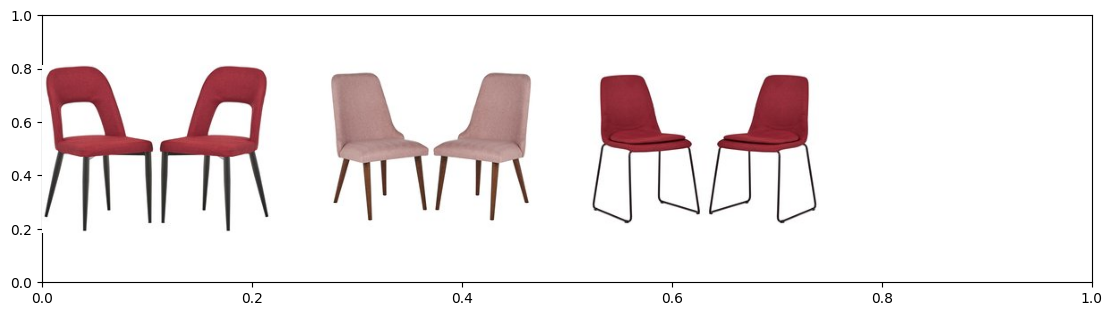

In [9]:
fig = plt.subplots(figsize=(12,3))
plt.subplots_adjust(right=1, top=1)

for i, image in enumerate(json_response["image_id"]):
    #json_doc = json.loads(doc.page_content) 
    image_path = "../artifacts/abo-images-small/images/small/" + image
    image_pil = Image.open(image_path).convert('RGB')
    #Image._show(image_pil)
    plt.subplot(1, 4, i+1)
    plt.imshow(image_pil)
    plt.axis("off")
    #plt.tight_layout()
  

In [22]:
import pandas as pd

In [14]:
json_file_path  = "../artifacts/dataset.json"

In [23]:
json_file = pd.read_json(json_file_path)

In [31]:
json_file.head(2)

,item_id,product_type,country,marketplace,domain_name,other_image_id,spin_id,3dmodel_id,color_code,brand_in_en_us,...,item_keywords_in_en_us,item_name_in_en_us,item_shape_in_en_us,material_in_en_us,model_name_in_en_us,pattern_in_en_us,product_description_in_en_us,height,width,path
0,B073ZTQ44Y,[{'value': 'GROCERY'}],US,Amazon,amazon.com,"[81laSOjKLwL, 61g2DDPfZHL, 51M39MBAwDL, 31C6QB...",None,None,None,Wickedly Prime,...,mustard,"Wickedly Prime Mustard, White Wine Jalapeno, 1...",None,None,None,None,None,1635,930,83/83222ad0.jpg
1,B00L7PIU3Q,[{'value': 'FINEEARRING'}],US,Amazon,amazon.com,"[61UdwSM3l-L, 71ZSeQAbeGL]",None,None,None,Amazon Collection,...,Fine Fashion,10k White Gold Swiss-Blue-Topaz and Diamond Ac...,None,metal,None,None,None,2098,1098,43/43e5efc9.jpg


In [30]:
json_file[json_file["item_id"] == "B073ZTQ44Y"]["other_image_id"].to_list()[0]

['81laSOjKLwL', '61g2DDPfZHL', '51M39MBAwDL', '31C6QBNw8YL', '719ZZw6xiKL']